In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SNU PLANETA - forecasting PM2.5 24hours later

[4. 대기] PM2.5 변화 초단기 예보 문제

서울시의 각 측정소별로 관측되는 PM2.5값의 향후 24시간 분량을 예측-예보

- 초미세먼지와 미세먼지는 매우 작은 크기로 호흡기를 통해 곧바로 혈액으로 들어갈 수 있어 우리의 건강에 심각한 악영향을 미칩니다. 단기적으로는 천식 발작, 급성 기관지염, 부정맥과 같은 증상을 악화시키고 미세먼지 농도가 높은 곳에서 오래 노출되는 경우 심혈관질환, 호흡기질환, 폐암 발생의 위험이 증가합니다. (출처: 질병관리리청)
- 에어코리아에서 수집한 서울 지역 25 곳의 PM2.5 측정 데이터와 방재기상관측자료(AWS) 날씨 데이터가 준비되어 있습니다.
- 각 미세먼지 관측소별 24시간 분량의 PM2.5 데이터와 인근 AWS관측소의 관측 결과를 이용하여 향후 24시간 분량의 PM2.5 수치 변화를 예측합니다.
- PM2.5와 AWS정보의 관측소 위치는 일치하지 않습니다. 위치가 다른 AWS 정보를 PM2.5 예측에 활용할 수 있도록 가공하는 것이 포인트입니다.

- best RMSE : 15.05

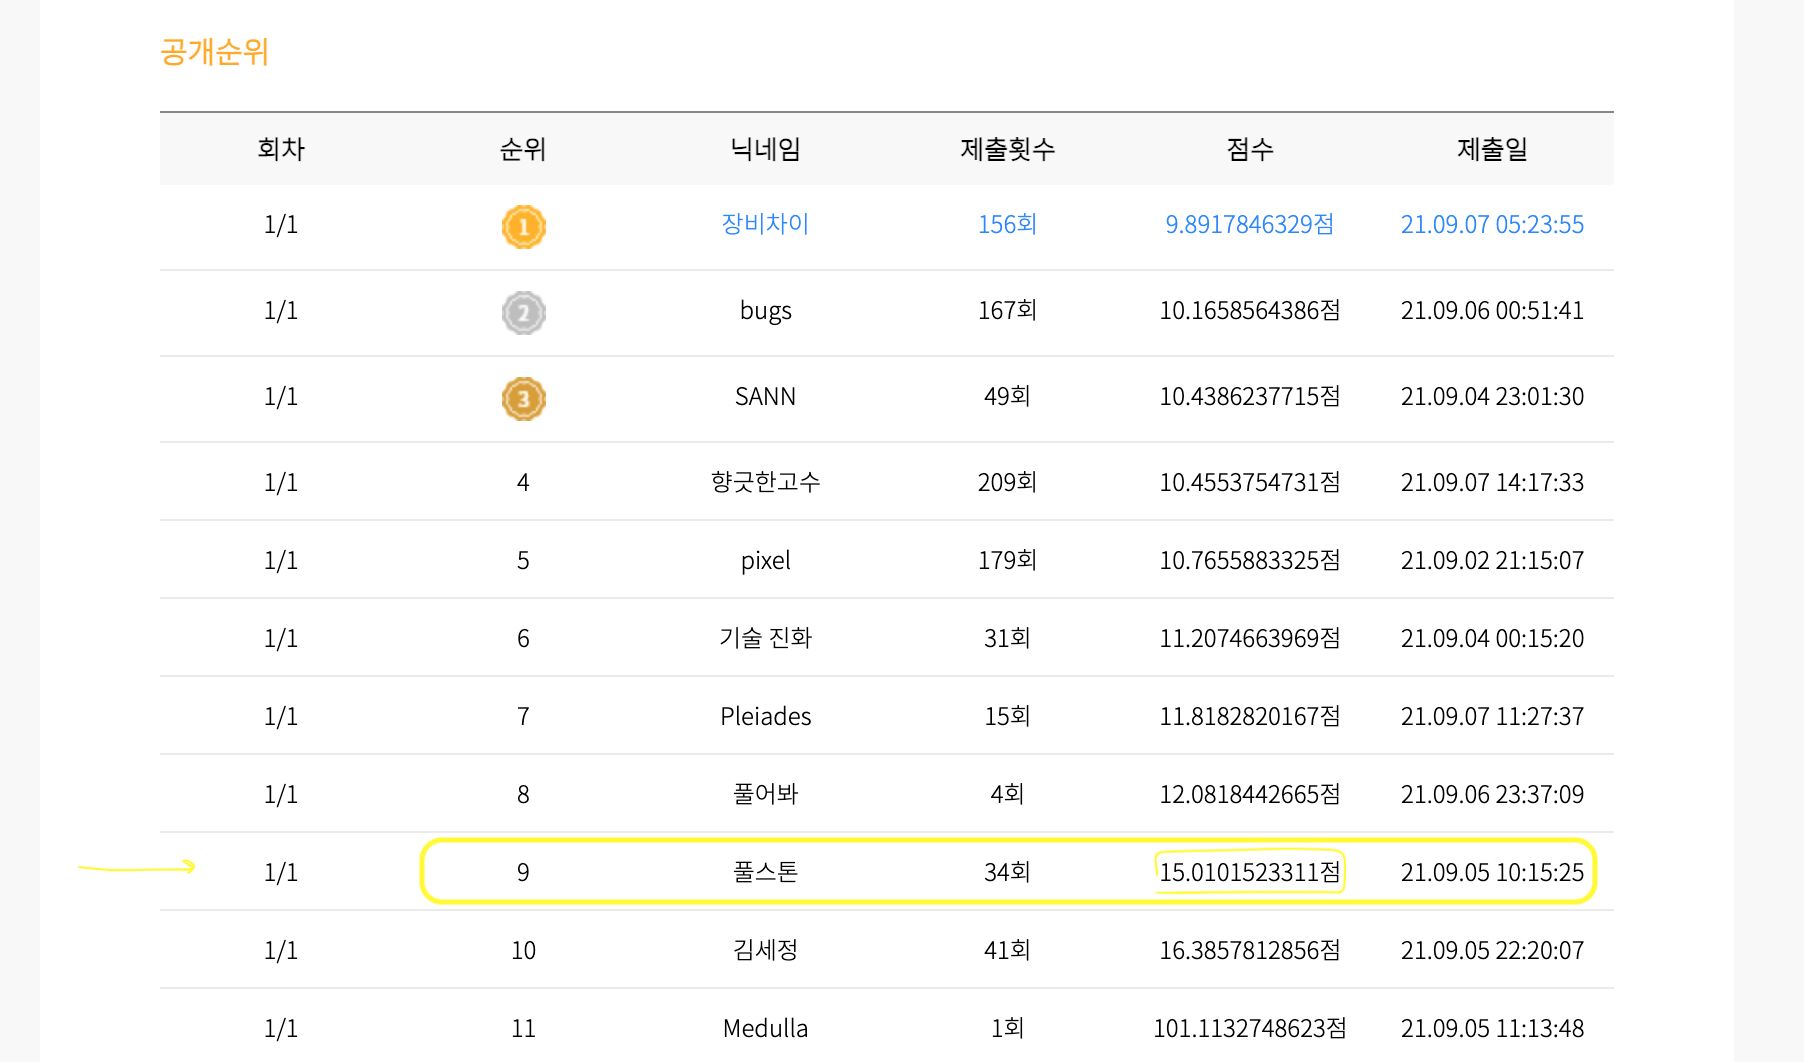

## 1. Data load

In [2]:
!gdown https://drive.google.com/u/0/uc?id=1BDLRo8NIVk9WEhhr5vW_C9n5zqckGLMH
!7z x '/content/4.______.zip' -odataset

Downloading...
From: https://drive.google.com/u/0/uc?id=1BDLRo8NIVk9WEhhr5vW_C9n5zqckGLMH
To: /content/4.______.zip
18.7MB [00:00, 114MB/s] 

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 18726404 bytes (18 MiB)

Extracting archive: /content/4.______.zip
--
Path = /content/4.______.zip
Type = zip
Physical Size = 18726404

  0%     21% 7 - train/train_input_aws.csv                                   41% 7 - train/train_input_aws.csv                                   66% 8 - train/train_input_pm25.csv                                   

In [1]:
%%capture
!pip install geopandas
!pip install scikit-gstat
import skgstat
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import folium
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt

import os

tf.random.set_seed(7)

In [2]:
data_dir = '/content/dataset'

# 훈련, 검증 데이터 경로 지정
train_input_aws_path = os.path.join(data_dir, 'train/train_input_aws.csv')
train_input_pm25_path = os.path.join(data_dir, 'train/train_input_pm25.csv')
train_output_path = os.path.join(data_dir, 'train/train_output_pm25.csv')

test_input_pm25_path = os.path.join(data_dir, 'test/test_input_pm25.csv')
test_input_aws_path = os.path.join(data_dir, 'test/test_input_aws.csv')
test_output_path = os.path.join(data_dir, 'test/sample_answer.csv')

# 지정한 경로에서 데이터 불러오기
# 훈련 데이터
train_input_aws_df = pd.read_csv(train_input_aws_path)
train_input_pm25_df = pd.read_csv(train_input_pm25_path)
train_output_df = pd.read_csv(train_output_path)

# 검증 데이터
test_input_aws_df = pd.read_csv(test_input_aws_path)
test_input_pm25_df = pd.read_csv(test_input_pm25_path)
submission = pd.read_csv(test_output_path)

# 장소 정보 불러오기
location_path = os.path.join(data_dir, 'train/locations.csv')
location_df = pd.read_csv(location_path)

In [3]:
print(train_input_aws_df.shape)
print(train_input_pm25_df.shape)
print(train_output_df.shape)

(1051200, 8)
(1095000, 4)
(1095000, 4)


In [4]:
train_nan = train_input_pm25_df[train_input_pm25_df['PM25'].isnull()]

## 2. Data Preprocess

In [5]:
# 습도는 0 미만 값을 갖지 않기 때문에 전처리해줌
minus_humidity = train_input_aws_df[train_input_aws_df['humidity'] < 0]

In [6]:
minus_humidity['humidity'].unique()

array([ -1.7, -99.9])

In [7]:
train_input_aws_df['humidity'].replace(-99.9, np.nan, inplace=True)
train_input_aws_df['humidity'].replace(-1.7, np.nan, inplace=True)

In [8]:
train_input_aws_df[train_input_aws_df['humidity'] < 0]

,id,time,loc_code,temperature,wind_direction,wind_speed,precipitation,humidity


In [9]:
# 장소카테고리별로 그룹
grouped_location_df = location_df.groupby('category')

# 장소를 aws, pm25로 나누어주기
aws_loc_df = grouped_location_df.get_group('aws').reset_index(drop=True)
pm25_loc_df = grouped_location_df.get_group('pm25').reset_index(drop=True)

In [10]:
# GeoDataFrame으로 변환
aws_loc_gdf = gpd.GeoDataFrame(aws_loc_df, geometry=gpd.points_from_xy(aws_loc_df.longitude, aws_loc_df.latitude))
pm25_loc_gdf = gpd.GeoDataFrame(pm25_loc_df, geometry=gpd.points_from_xy(pm25_loc_df.longitude, pm25_loc_df.latitude))

In [11]:
# 좌표계 변환
aws_loc_gdf.crs = {'init':'epsg:4326'}
pm25_loc_gdf.crs = {'init':'epsg:4326'}

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [12]:
# 미터 좌표계로 변환
aws_loc_gdf = aws_loc_gdf.to_crs({'init':'epsg:5179'})
pm25_loc_gdf = pm25_loc_gdf.to_crs({'init':'epsg:5179'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [13]:
# aws_loc_df 시각화
locations = aws_loc_df[['latitude', 'longitude']]
locationlist = locations.values.tolist()

center = locationlist[19]  # 용산 aws 를 중심으로 folium map
map = folium.Map(location=center, zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=aws_loc_df['loc_name'][point]).add_to(map)
map

In [14]:
# aws, pm25 좌표 딕셔너리 생성
def geo_var(df, dict):
  for i in df['loc_name']:
    x = df.loc[df.loc_name == i, "geometry"].squeeze()
    dict[i] = x
  return dict

aws_dict ={}
pm25_dict={}

aws_dict = geo_var(aws_loc_gdf, aws_dict)
pm25_dict = geo_var(pm25_loc_gdf, pm25_dict)

In [15]:
# pm25의 각 좌표와 가장 가까운 aws 좌표를 매칭
def nearest_distance(dict1, dict2):
  distance={}
  for t in list(dict1.items()):
    k1 = t[0]
    v1 = t[1]
    shortest = v1.distance(list(dict2.values())[0])
    for m in list(dict2.items()):
      k2 = m[0]
      v2 = m[1]
      if v1.distance(v2) < shortest:
        shortest = v1.distance(v2)
        index=k2
    distance[k1] = index
  return distance

pm25_nearest = nearest_distance(pm25_dict, aws_dict)

In [16]:
# 매칭한 장소 이름과 좌표를 데이터 프레임으로 변환
pm25_nearest = pd.DataFrame(list(pm25_nearest.items()), columns=['loc_name','aws_loc_name'])

In [17]:
# pm25_loc_df, aws_loc_df에 매칭한 장소를 merge

pm25_loc_df = pd.merge(pm25_loc_df, pm25_nearest, how = 'inner', on=['loc_name'])

aws_loc_df = aws_loc_df.rename(columns={'loc_name': 'aws_loc_name'})

In [18]:
# Merge (pm25_loc_df, aws_loc_df)
loc_df = pd.merge(pm25_loc_df, aws_loc_df, how='inner', on = ['aws_loc_name'])

# get id for every pm25 loc_code
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
loc_df['loc_id'] = lbl.fit_transform(loc_df['loc_code_x'])

In [19]:
# make dataframe with loc_id
pm25_loc_id = loc_df[['loc_code_x','loc_id']]
aws_loc_id = loc_df[['loc_code_y', 'loc_id']]

pm25_loc_id = pm25_loc_id.rename(columns={'loc_code_x':'loc_code'})
aws_loc_id = aws_loc_id.rename(columns={'loc_code_y':'loc_code'})

In [20]:
pm25_loc_df = pd.merge(pm25_loc_df, pm25_loc_id, how='inner', on='loc_code')
aws_loc_df = pd.merge(aws_loc_df, aws_loc_id, how='inner', on='loc_code')

In [21]:
pm25_loc_df = pm25_loc_df[['loc_code','latitude', 'longitude','loc_id']]
aws_loc_df = aws_loc_df[['loc_code','latitude', 'longitude','loc_id']]

In [22]:
# first attempt, 별로임
'''
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
aws_loc_df['loc_id'] = lbl.fit_transform(aws_loc_df['loc_name'])
aws_loc_df.head()

loc_id_map = aws_loc_df['loc_name'].to_dict()
pm25_loc_df['loc_name'] = pm25_loc_df['loc_name'].map(lambda x: x[:-1])

loc_id_map[22] = '광진'
loc_id_map[23] = '동작'

loc_id_map = {v: k for k, v in loc_id_map.items()}
loc_id_map['종로'] = 10
loc_id_map['중'] = 12
loc_id_map['영등포'] = 18

print(loc_id_map)

pm25_loc_df['loc_id'] = pm25_loc_df['loc_name'].map(loc_id_map.get).astype(int)

aws = aws_loc_df.drop(['category', 'loc_name', 'latitude', 'longitude'], axis=1)
pm25 = pm25_loc_df.drop(['category', 'loc_name', 'latitude', 'longitude'], axis=1)

pm25_aws_loc = pd.merge(pm25, aws, how='inner', on=['loc_id'])
pm25_aws_loc.rename(columns={'loc_code_x':'pm25_loc_code', 'loc_code_y':'aws_loc_code'}, inplace=True)
pm25_aws_loc['loc_id'] = lbl.fit_transform(pm25_aws_loc['pm25_loc_code'])

pm25_loc_id = pm25_aws_loc.iloc[:,:2]
aws_loc_id = pm25_aws_loc.iloc[:,1:]

pm25_loc_id.rename(columns={'pm25_loc_code':'loc_code'}, inplace=True)
aws_loc_id.rename(columns={'aws_loc_code':'loc_code'}, inplace=True)
'''

"\nfrom sklearn.preprocessing import LabelEncoder\nlbl = LabelEncoder()\naws_loc_df['loc_id'] = lbl.fit_transform(aws_loc_df['loc_name'])\naws_loc_df.head()\n\nloc_id_map = aws_loc_df['loc_name'].to_dict()\npm25_loc_df['loc_name'] = pm25_loc_df['loc_name'].map(lambda x: x[:-1])\n\nloc_id_map[22] = '광진'\nloc_id_map[23] = '동작'\n\nloc_id_map = {v: k for k, v in loc_id_map.items()}\nloc_id_map['종로'] = 10\nloc_id_map['중'] = 12\nloc_id_map['영등포'] = 18\n\nprint(loc_id_map)\n\npm25_loc_df['loc_id'] = pm25_loc_df['loc_name'].map(loc_id_map.get).astype(int)\n\naws = aws_loc_df.drop(['category', 'loc_name', 'latitude', 'longitude'], axis=1)\npm25 = pm25_loc_df.drop(['category', 'loc_name', 'latitude', 'longitude'], axis=1)\n\npm25_aws_loc = pd.merge(pm25, aws, how='inner', on=['loc_id'])\npm25_aws_loc.rename(columns={'loc_code_x':'pm25_loc_code', 'loc_code_y':'aws_loc_code'}, inplace=True)\npm25_aws_loc['loc_id'] = lbl.fit_transform(pm25_aws_loc['pm25_loc_code'])\n\npm25_loc_id = pm25_aws_loc.ilo

In [23]:
# loc_id 정보를 매핑
train_input_pm25_df = pd.merge(train_input_pm25_df, pm25_loc_df, how='inner', on=['loc_code'])
test_input_pm25_df = pd.merge(test_input_pm25_df, pm25_loc_df, how='inner', on=['loc_code'])

train_input_aws_df = pd.merge(train_input_aws_df, aws_loc_df, how='inner', on=['loc_code'])
test_input_aws_df = pd.merge(test_input_aws_df, aws_loc_df, how='inner', on=['loc_code'])

# 필요 없는 정보는 제거
train_input_aws_df = train_input_aws_df.drop(['id', 'loc_code'], axis=1)
test_input_aws_df = test_input_aws_df.drop(['id', 'loc_code'], axis=1)

In [24]:
#메모리 오류
'''
import scipy
from scipy.interpolate import Rbf

def euclidean_norm_numpy(x1, x2):
    return np.linalg.norm(x1 - x2, axis=0)

rbf = Rbf(train_input_pm25_df.latitude.values,train_input_pm25_df.longitude.values,train_input_pm25_df.PM25.values,
          epsilon=2)
'''

'\nimport scipy\nfrom scipy.interpolate import Rbf\n\ndef euclidean_norm_numpy(x1, x2):\n    return np.linalg.norm(x1 - x2, axis=0)\n\nrbf = Rbf(train_input_pm25_df.latitude.values,train_input_pm25_df.longitude.values,train_input_pm25_df.PM25.values,\n          epsilon=2)\n'

In [25]:
'''
from datetime import datetime, timedelta
train_input_aws_df['datetime'] = train_input_aws_df['datetime'].apply(lambda x: x - timedelta(hours=24))
test_input_aws_df['datetime'] = test_input_aws_df['datetime'].apply(lambda x: x - timedelta(hours=24))

def to_integer(dt_time):
    return 1000000*dt_time.year + 10000*dt_time.month + 100*dt_time.day + dt_time.hour

train_input_aws_df['time'] = train_input_aws_df['datetime'].apply(lambda x: to_integer(x))
test_input_aws_df['time'] = test_input_aws_df['datetime'].apply(lambda x: to_integer(x))
'''

"\nfrom datetime import datetime, timedelta\ntrain_input_aws_df['datetime'] = train_input_aws_df['datetime'].apply(lambda x: x - timedelta(hours=24))\ntest_input_aws_df['datetime'] = test_input_aws_df['datetime'].apply(lambda x: x - timedelta(hours=24))\n\ndef to_integer(dt_time):\n    return 1000000*dt_time.year + 10000*dt_time.month + 100*dt_time.day + dt_time.hour\n\ntrain_input_aws_df['time'] = train_input_aws_df['datetime'].apply(lambda x: to_integer(x))\ntest_input_aws_df['time'] = test_input_aws_df['datetime'].apply(lambda x: to_integer(x))\n"

In [26]:
train_input_pm25_df = train_input_pm25_df.drop(['latitude','longitude'], axis=1)
train_input_aws_df = train_input_aws_df.drop(['latitude','longitude'], axis=1)

test_input_pm25_df = test_input_pm25_df.drop(['latitude','longitude'], axis=1)
test_input_aws_df = test_input_aws_df.drop(['latitude','longitude'], axis=1)

In [27]:
# 훈련 데이터셋, 테스트 데이터셋 생성
# pm25 데이터와 aws 데이터를 merge
train = pd.merge(train_input_pm25_df, train_input_aws_df, how='left', on=['loc_id', 'time'])
test = pd.merge(test_input_pm25_df, test_input_aws_df, how='left', on=['loc_id', 'time'])

In [28]:
train = train.sort_values(by=['loc_id', 'time']).interpolate(method='pad')
test = test.sort_values(by=['loc_id', 'time']).interpolate(method='pad')

In [29]:
train['datetime'] = pd.to_datetime(train['time'], format='%Y%m%d%H')
test['datetime'] = pd.to_datetime(test['time'], format='%Y%m%d%H')

# 결측치 보간
train = train.set_index('datetime').interpolate(method='time') # (1051200, 9) =>  1051200 = 24(시) *  * 365(일) * 5(년) * 24(관측소)
test = test.set_index('datetime').interpolate(method='time') # (1051200, 9) =>  1051200 = 24(시) *  * 365(일) * 5(년) * 24(관측소)

In [30]:
# 결측치 개수 확인
print(train.isnull().sum())
print(test.isnull().sum())

id                  0
time                0
loc_code            0
PM25                1
loc_id              0
temperature         0
wind_direction      0
wind_speed          0
precipitation       0
humidity          128
dtype: int64
id                   0
time                 0
loc_code             0
PM25                 0
loc_id               0
temperature          0
wind_direction       0
wind_speed           0
precipitation        0
humidity          3398
dtype: int64


In [31]:
# 결측치 채우기
train['humidity'] = train['humidity'].fillna(train['humidity'].mean())
test['humidity'] = test['humidity'].fillna(test['humidity'].mean())

train = train.fillna(7.0)

# train 데이터 길이 변수 생성: 향후 데이터 합치고 나눌 때 사용.
split = train.shape[0]

In [32]:
print(split)

1095000


## Feature Engineering

In [33]:
# 훈련, 검증 데이터셋 통합 total 데이터셋 생성
total = pd.concat([train, test])

In [34]:
wv = total.pop('wind_speed')
max_wv = wv.max()

# Convert to radians.
wd_rad = total.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
total['Wx'] = wv*np.cos(wd_rad)
total['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
total['max Wx'] = max_wv*np.cos(wd_rad)
total['max Wy'] = max_wv*np.sin(wd_rad)

In [35]:
# datetime 정보 변수 생성
total = total.reset_index()

import datetime
timestamp_s = total['datetime'].map(datetime.datetime.timestamp)

day = 24*60*60
month = 4*30.4*day
year = (365.2425)*day

total['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
total['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
total['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
total['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
total['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
total['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [36]:
# 인덱스 set, 필요 없는 loc_id 제거
total = total.set_index('datetime')
total = total.drop(['loc_id'], axis=1)

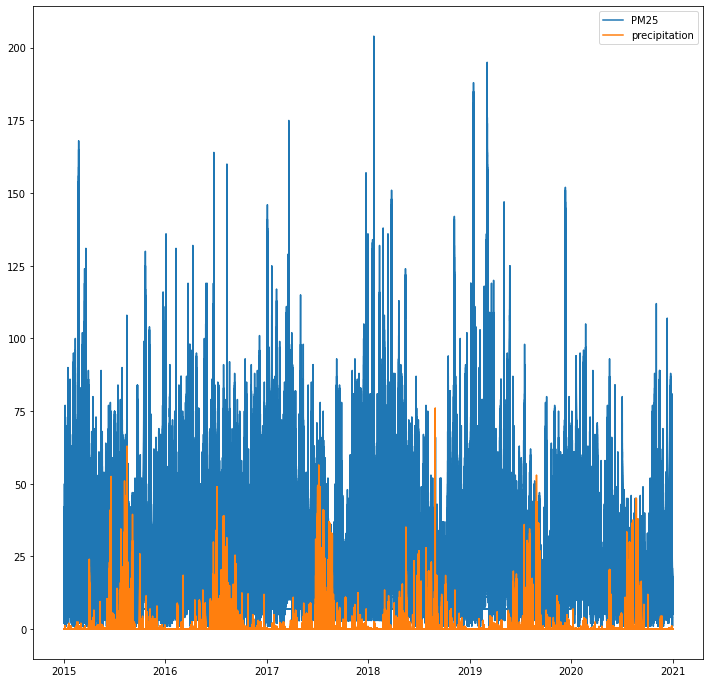

In [37]:
plt.figure(figsize=(12,12))
plt.plot(total.index, total[['PM25', 'precipitation']])
plt.legend(['PM25', 'precipitation'])
plt.show()

In [38]:
!pip install statsmodels
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [39]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    plt.subplot(211)
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.tight_layout()
    plt.show(block=False)

PM25


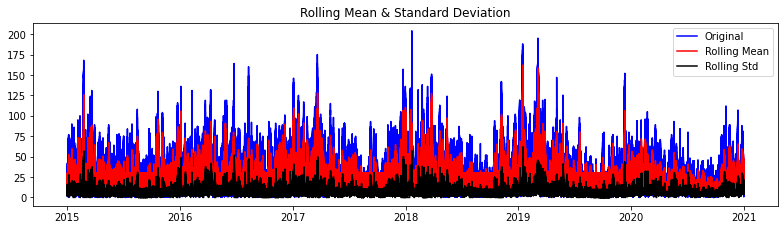

temperature


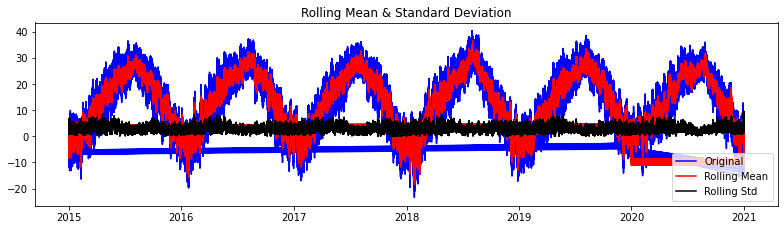

precipitation


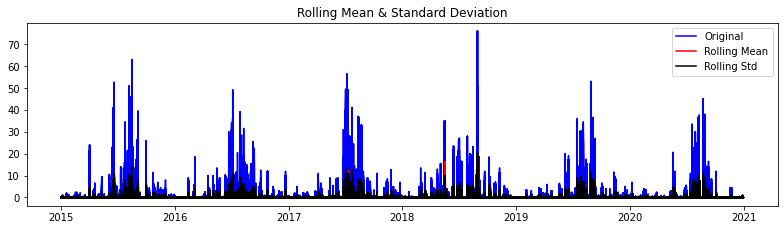

humidity


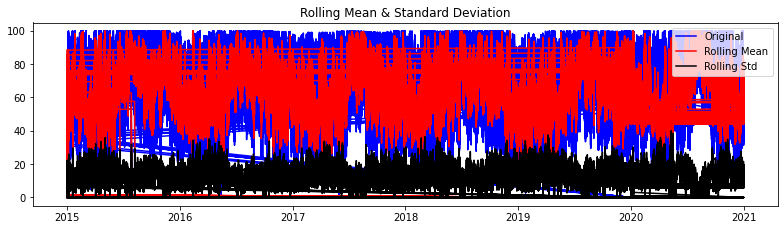

Wx


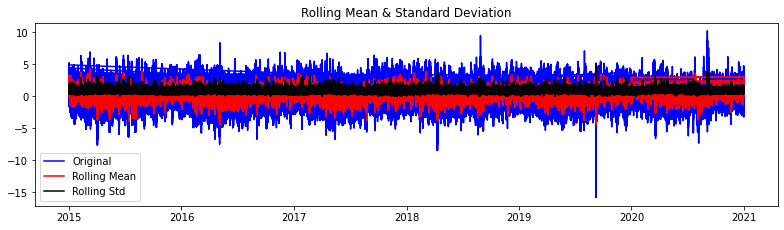

Wy


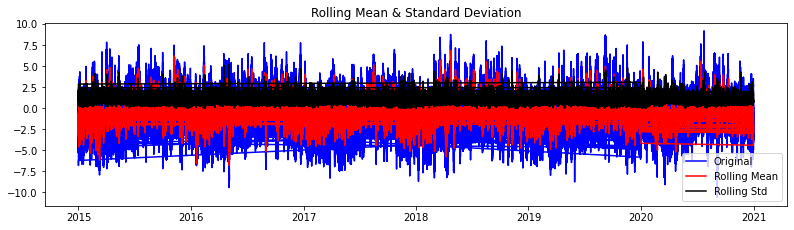

In [40]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose    

cols = ['PM25',	'temperature',	'precipitation',	'humidity', 'Wx',	'Wy']

plt.rcParams["figure.figsize"] = (11,6)

for col in cols:
  # 메모리 에러
  # augmented_dickey_fuller_test(total[col])
  print(col)
  plot_rolling_statistics(total[col], window=24)

In [41]:
# train, test split
train = total[:split][:]
test = total[split:][:]

In [42]:
display(train)

,id,time,loc_code,PM25,temperature,precipitation,humidity,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Month sin,Month cos,Year sin,Year cos
datetime,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,2015010100,111121,7.0,-6.9,0.0,36.742313,1.834568,-3.778143,7.338270,-15.112571,1.232357e-12,1.000000,0.859054,0.511885,0.001505,0.999999
2015-01-01 01:00:00,0.0,2015010101,111121,7.0,-7.4,0.0,36.742313,1.698603,-1.834325,11.414614,-12.326662,2.588190e-01,0.965926,0.860154,0.510034,0.002222,0.999998
2015-01-01 02:00:00,0.0,2015010102,111121,10.0,-7.9,0.0,36.742313,2.037430,-2.845853,9.779666,-13.660093,5.000000e-01,0.866025,0.861250,0.508181,0.002939,0.999996
2015-01-01 03:00:00,0.0,2015010103,111121,10.0,-8.3,0.0,36.742313,1.888047,-2.067675,11.328280,-12.406050,7.071068e-01,0.707107,0.862342,0.506326,0.003656,0.999993
2015-01-01 04:00:00,0.0,2015010104,111121,11.0,-8.6,0.0,36.742313,1.961752,-1.855136,12.206454,-11.543070,8.660254e-01,0.500000,0.863430,0.504468,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,1824.0,2019123019,111311,39.0,1.7,0.0,62.100000,1.600274,-1.920709,10.753843,-12.907163,-9.659258e-01,0.258819,0.879269,0.476326,-0.022935,0.999737
2019-12-30 20:00:00,1824.0,2019123020,111311,30.0,-0.3,0.0,60.400000,2.488015,-2.872243,10.999646,-12.698338,-8.660254e-01,0.500000,0.880292,0.474432,-0.022218,0.999753
2019-12-30 21:00:00,1824.0,2019123021,111311,26.0,-1.6,0.0,65.200000,1.110566,-3.319133,5.330718,-15.931837,-7.071068e-01,0.707107,0.881312,0.472536,-0.021502,0.999769


## 시계열 분석

In [43]:
def reshape_dataframe(df, loc_df):
  # reshape the dataframe into 3d array with indexing [loc_code, value, time-id]
  # result[loc_code, value, time-id] will give you the values of the 24 hours
  len_loc = len(loc_df)
  col_values = df.columns[3:]  # not going to use `id`, `time`, `loc_code`
  len_values = len(col_values)
  len_id = int(df['id'].max()+1)
  len_term = 24
  result = np.ndarray((len_loc, len_values, len_id, len_term))

  # group by loc_code and id
  grouped_df = df.groupby(['loc_code', 'id'])
  group_keys = list(grouped_df.groups.keys())
  group_keys.sort()

  for i_key, (loc_key, id_key) in enumerate(group_keys):
    i_loc = int(i_key/len_id)
    i_key = i_key%len_id
    cur_df = grouped_df.get_group((loc_key, id_key))
    for icol, col in enumerate(col_values):
      result[i_loc][icol][i_key] = cur_df[col].to_numpy()
  return result

In [44]:
# 시계열 데이터 훈련에 적합한 numpy array 형태로 변환
train = reshape_dataframe(train, pm25_loc_df)
test_df = reshape_dataframe(test, pm25_loc_df)

train_df = train[:,:,:-364,:]
val_df = train[:,:,-364:,:]

In [45]:
# 데이터 정규화
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [46]:
# 타겟 데이터 생성
train_output_df['datetime'] = pd.to_datetime(train_output_df['time'], format='%Y%m%d%H')
train_output_df = train_output_df.sort_values(by=['loc_code', 'time']).interpolate(method='nearest')
train_output_df = train_output_df.set_index('datetime').interpolate(method='time')

target = reshape_dataframe(train_output_df, pm25_loc_df)

In [47]:
X = train.copy()
y = target.copy()

print(X.shape)
print(y.shape)

(25, 14, 1825, 24)
(25, 1, 1825, 24)


In [48]:
# feature 개수
num_features = train.shape[1]

In [49]:
X_train = train_df.copy()
X_val = val_df.copy()
y_train = target[:,:,:-364,:]
y_val = target[:,:,-364:,:]

days = X_train.shape[2]

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(25, 14, 1461, 24)
(25, 14, 364, 24)
(25, 1, 1461, 24)
(25, 1, 364, 24)


In [50]:
X = X.reshape(25*train.shape[2], 24, num_features)
y = y.reshape(25*train.shape[2], 24)

X_train = X_train.reshape(25*days, 24, num_features)
X_val = X_val.reshape(25*364, 24, num_features)
y_train = y_train.reshape(25*days, 24)
y_val = y_val.reshape(25*364, 24)

## 3. Model train

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

BATCH_SIZE = 256
EPOCHS = 20

# 1
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences = True, input_shape=(24, 14)))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam())

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 64)            20224     
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 32)            12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             33        
Total params: 32,673
Trainable params: 32,673
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
143/143 [==============================] - 25s 156ms/step - loss: 458.1846 - val_loss: 488.0808
Epoch 2/20
143/143 [==============================] - 22s 152ms/step - loss: 304.5270 - val_loss: 465.4893
Epoch 3/20
143/143 [==============================] - 22s 151ms/step - loss: 286.8681 - val_loss: 461.4575
Epoch 4/20
143/143 [==============================] - 22s 154

In [52]:
# 2
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(24,num_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(24))
model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam())

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 64)            20224     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1560      
Total params: 54,808
Trainable params: 54,808
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
143/143 [==============================] - 25s 159ms/step - loss: 415.4373 - val_loss: 442.7603
Epoch 2/20
143/143 [==============================] - 22s 155ms/step - loss: 269.9079 - val_loss: 445.5402
Epoch 3/20
143/143 [==============================] - 22s 153ms/step - loss: 268.4773 - val_loss: 443.7144


In [53]:
# 3
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta


residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam())

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/20
143/143 [==============================] - 25s 156ms/step - loss: 269.4516 - val_loss: 435.6482
Epoch 2/20
143/143 [==============================] - 21s 149ms/step - loss: 267.8181 - val_loss: 439.7525
Epoch 3/20
143/143 [==============================] - 22s 152ms/step - loss: 264.9763 - val_loss: 435.7835


In [54]:
# 4
CONV_WIDTH = 3
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH),
                           input_shape=(24,num_features)),
    tf.keras.layers.Conv1D(32, kernel_size=(CONV_WIDTH), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(24)
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam())

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/20
143/143 [==============================] - 3s 8ms/step - loss: 589.8397 - val_loss: 526.9261
Epoch 2/20
143/143 [==============================] - 1s 7ms/step - loss: 282.8010 - val_loss: 453.1385
Epoch 3/20
143/143 [==============================] - 1s 6ms/step - loss: 269.4257 - val_loss: 448.0451
Epoch 4/20
143/143 [==============================] - 1s 6ms/step - loss: 268.0648 - val_loss: 453.8185
Epoch 5/20
143/143 [==============================] - 1s 7ms/step - loss: 267.0359 - val_loss: 441.3051
Epoch 6/20
143/143 [==============================] - 1s 6ms/step - loss: 265.6201 - val_loss: 442.5892
Epoch 7/20
143/143 [==============================] - 1s 6ms/step - loss: 265.0372 - val_loss: 440.9503
Epoch 8/20
143/143 [==============================] - 1s 6ms/step - loss: 264.2732 - val_loss: 441.0927
Epoch 9/20
143/143 [==============================] - 1s 6ms/step - loss: 261.6372 - val_loss: 444.4929


In [55]:
test_input = test_df.reshape(25*183, 24, num_features)
y_pred = model.predict(test_input)
y_pred = y_pred.reshape(-1,1)

In [56]:
y_pred

array([[33.67022 ],
       [34.613167],
       [33.905014],
       ...,
       [22.588255],
       [22.696257],
       [22.657822]], dtype=float32)

In [57]:
# submission
submission['PM25'] = y_pred
submission.to_csv('/content/drive/MyDrive/air_submission.csv', index=False)
sub_path = '/content/drive/MyDrive/air_submission.csv'

In [58]:
submission

,id,time,loc_code,PM25
0,0,2020010200,111121,33.670219
1,0,2020010200,111123,34.613167
2,0,2020010200,111131,33.905014
3,0,2020010200,111141,34.875870
4,0,2020010200,111142,30.996456
...,...,...,...,...
109795,182,2020123123,111274,21.359739
109796,182,2020123123,111281,21.513458
109797,182,2020123123,111291,22.588255
109798,182,2020123123,111301,22.696257


-----------------

- 아래는 tensorflow tutorial (time-series)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

In [ ]:
def plot(self, model=None, plot_col='PM25', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w1.train.element_spec

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      callbacks=[early_stopping])
  return history

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=24, label_columns=['PM25'])

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.test

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

In [ ]:
performance

In [ ]:
MAX_EPOCHS = 5

In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

In [ ]:
y_pred = lstm_model.predict(wide_window.test)

In [ ]:
y_pred.shape